In [63]:
#import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numpy.linalg import inv
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.colors as colors
from matplotlib import rc
plt.rcParams["font.serif"]       = 'Times New Roman'
plt.rcParams["xtick.major.size"] = 10
plt.rcParams["ytick.major.size"] = 10
plt.rcParams["xtick.minor.size"] = 5
plt.rcParams["ytick.minor.size"] = 5
plt.rcParams["xtick.labelsize"]  = 25
plt.rcParams["ytick.labelsize"]  = 25

plt.rcParams["legend.title_fontsize"]=25
import sys

In [64]:
hbar=1.06e-34
q=1.6e-19
m=0.25*9.1e-31
IE=(q*q)/(2*np.pi*hbar)
Ef=0.1
kT=0.025
a=3e-10
t0=(hbar**2)/(2*m*a**2*q)
print('t0',t0)

case=2 #0: no barrier, 1: one barrier, 2: two barriers

N=np.zeros(3) #N[0/1/2]=number of points in the source/channel/drain
V=0 #applied bias

#Energy grid
NE=501 #number of energy points
E=np.linspace(-0.2,0.8,NE) #energy range 
dE=E[2]-E[1]
zplus=1j*1e-12 #small imaginary number
TM=np.zeros(NE)

t0 1.7148962148962152


In [65]:
def setup(argument):
    N=np.zeros(3, dtype=int)
    match argument:
        case 0: #No barrier
            N[0]=15
            N[1]=30
            N[2]=15
            UB=np.ones(N.sum())*0
        case 1: #Tunneling barrier
            N[0]=15 
            N[1]=16
            N[2]=15
            UB=np.concatenate((np.zeros(N[0]),0.4*np.ones(4),np.zeros(N[1]-4), np.zeros(N[2])),axis=None)
        case 2: #Resonant tunneling for 2 barriers
            N[0]=15 
            N[1]=16
            N[2]=15
            UB=np.concatenate((np.zeros(N[0]),0.4*np.ones(4),np.zeros(N[1]-8),0.4*np.ones(4),np.zeros(N[2])),axis=None)
        case _:
            raise ValueError("Not a valid setup argument")
    return N,UB

In [66]:
N,UB=setup(case)
Np=N.sum()
print(Np)

46


In [67]:
#Construct a hamiltonian and add the potential due to barrier
H=2*t0*np.diag(np.ones(Np)) - t0*np.diag(np.ones(Np-1),1) - t0*np.diag(np.ones(Np-1),-1)
H=H+np.diag(UB)

#Define fermi energies and potential due to bias
mu1=Ef+V/2
mu2=Ef-V/2
f1=1./(1.+np.exp(E-mu1)/kT)
f2=1./(1.+np.exp(E-mu2)/kT)
U1=V*np.concatenate((0.5*np.ones(N[0]),np.linspace(0.5,-0.5,N[1]), -0.5*np.ones(N[2])),axis=None)
U1=U1.conj().T #applied potential profile
#print(U1)

In [68]:
#Compute transmission coefficient, i.e. probability that an electron will transmit from source to drain
I=0. #Current
for k in range(0,NE):
    sig1=np.zeros((Np,Np),dtype=complex)
    sig2=np.zeros((Np,Np),dtype=complex)
    sig3=np.zeros((Np,Np),dtype=complex)
    ck = 1.-((E[k]+zplus-U1[0]-UB[0])/(2*t0))
    ka = np.arccos(ck)
    sig1[0][0]=-t0*np.exp(1j*ka)
    gam1=1j*(sig1 - sig1.conj().T)
    
    ck = 1-((E[k]+zplus-U1[Np-1]-UB[Np-1])/(2*t0))
    ka = np.arccos(ck)
    sig2[Np-1][Np-1]=-t0*np.exp(1j*ka)
    gam2=1j*(sig2 - sig2.conj().T)    
    
    G=inv(((E[k]+zplus)*np.eye(Np))- H - np.diag(U1) - sig1 - sig2)
    TM[k]=np.real(np.trace(gam1@G@gam2@G.conj().T))
    I=I+(dE*IE*TM[k]*(f1[k]-f2[k]))
print('Voltage, V: ', V)
print('Current, I: ', I)

Voltage, V:  0
Current, I:  0.0


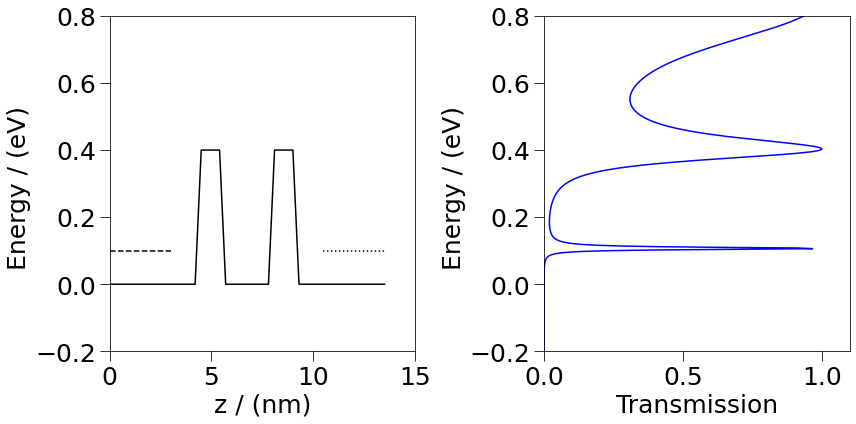

In [69]:
XX=a*1e9*np.arange(Np)
XS=XX[0:N[0]-4]
XD=XX[N[0]+N[1]+5-1:Np]

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
fig.patch.set_facecolor('white')

#ax1.legend(prop={'size': 30},loc='lower right')

ax[0].plot(XX, U1+UB,'k')
ax[0].plot(XS,mu1*np.ones(N[0]-4),'k--')
ax[0].plot(XD,mu2*np.ones(N[2]-4),'k:')
ax[1].plot(TM,E,'b')
ax[0].set_xlim(0,15)
ax[0].set_ylim(-0.2,0.8)
ax[1].set_xlim(0,1.1)
ax[1].set_ylim(-0.2,0.8)
ax[0].set_xlabel(r'z / (nm)', fontsize=25)
ax[0].set_ylabel(r'Energy / (eV) ', fontsize=25)
ax[1].set_xlabel(r'Transmission', fontsize=25)
ax[1].set_ylabel(r'Energy / (eV) ', fontsize=25)
fig.tight_layout()
#plt.savefig(path+'V_ForcedInOut.png', bbox_inches = "tight")#